In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.integrate import odeint
sns.set()
%matplotlib inline

In [2]:
# ipython --pylab

# set up a dictionary of parameters

E_params = {'E_leak' : -7.0e-2, # Eleak is set close to the resting potentail of the cell -70mV.
            'G_leak' : 3.0e-09,
            'C_m'    : 3.0e-11,
            'I_ext'  : 0*1.0e-10}

Na_params = {'Na_E': 5.0e-2, #Reversal potential for Na.
             'Na_G'          : 1.0e-6, #Maximum sodium conductance through the membrane.
             'k_Na_act'      : 3.0e+0, #
             
             'A_alpha_m_act' : 2.0e+5,
             'B_alpha_m_act' : -4.0e-2,
             'C_alpha_m_act' : 1.0e-3,
             
             'A_beta_m_act'  : 6.0e+4,
             'B_beta_m_act'  : -4.9e-2,
             'C_beta_m_act'  : 2.0e-2,
             
             'l_Na_inact'    : 1.0e+0,
             
             'A_alpha_m_inact' : 8.0e+4,
             'B_alpha_m_inact' : -4.0e-2,
             'C_alpha_m_inact' : 1.0e-3,
             
             'A_beta_m_inact'  : 4.0e+2,
             'B_beta_m_inact'  : -3.6e-2,
             'C_beta_m_inact'  : 2.0e-3}

K_params = {'k_E': -9.0e-2,
            'k_G'           : 2.0e-7,
            'k_K'           : 4.0e+0,
            
            'A_alpha_m_act' : 2.0e+4,
            'B_alpha_m_act' : -3.1e-2,
            'C_alpha_m_act' : 8.0e-4,
            
            'A_beta_m_act'  : 5.0e+3,
            'B_beta_m_act'  : -2.8e-2,
            'C_beta_m_act'  : 4.0e-4}

params = {'E_params'  : E_params,
        'Na_params' : Na_params,
        'K_params'  : K_params}

In [3]:
E_params

{'E_leak': -0.07, 'G_leak': 3e-09, 'C_m': 3e-11, 'I_ext': 0.0}

In [4]:
K_params

{'k_E': -0.09,
 'k_G': 2e-07,
 'k_K': 4.0,
 'A_alpha_m_act': 20000.0,
 'B_alpha_m_act': -0.031,
 'C_alpha_m_act': 0.0008,
 'A_beta_m_act': 5000.0,
 'B_beta_m_act': -0.028,
 'C_beta_m_act': 0.0004}

In [5]:
Na_params

{'Na_E': 0.05,
 'Na_G': 1e-06,
 'k_Na_act': 3.0,
 'A_alpha_m_act': 200000.0,
 'B_alpha_m_act': -0.04,
 'C_alpha_m_act': 0.001,
 'A_beta_m_act': 60000.0,
 'B_beta_m_act': -0.049,
 'C_beta_m_act': 0.02,
 'l_Na_inact': 1.0,
 'A_alpha_m_inact': 80000.0,
 'B_alpha_m_inact': -0.04,
 'C_alpha_m_inact': 0.001,
 'A_beta_m_inact': 400.0,
 'B_beta_m_inact': -0.036,
 'C_beta_m_inact': 0.002}

In [6]:
params

{'E_params': {'E_leak': -0.07, 'G_leak': 3e-09, 'C_m': 3e-11, 'I_ext': 0.0},
 'Na_params': {'Na_E': 0.05,
  'Na_G': 1e-06,
  'k_Na_act': 3.0,
  'A_alpha_m_act': 200000.0,
  'B_alpha_m_act': -0.04,
  'C_alpha_m_act': 0.001,
  'A_beta_m_act': 60000.0,
  'B_beta_m_act': -0.049,
  'C_beta_m_act': 0.02,
  'l_Na_inact': 1.0,
  'A_alpha_m_inact': 80000.0,
  'B_alpha_m_inact': -0.04,
  'C_alpha_m_inact': 0.001,
  'A_beta_m_inact': 400.0,
  'B_beta_m_inact': -0.036,
  'C_beta_m_inact': 0.002},
 'K_params': {'k_E': -0.09,
  'k_G': 2e-07,
  'k_K': 4.0,
  'A_alpha_m_act': 20000.0,
  'B_alpha_m_act': -0.031,
  'C_alpha_m_act': 0.0008,
  'A_beta_m_act': 5000.0,
  'B_beta_m_act': -0.028,
  'C_beta_m_act': 0.0004}}

In [7]:
E_params['E_leak']
E_params['G_leak']

3e-09

In [8]:
# define our ODE function
import math

def neuron(state, t, params):
        """
         Purpose: simulate Hodgkin and Huxley model for the action potential using
         the equations from Ekeberg et al, Biol Cyb, 1991.
         Input: state ([E m h n] (ie [membrane potential; activation of
                  Na++ channel; inactivation of Na++ channel; activation of K+
                  channel]),
                t (time),
                and the params (parameters of neuron; see Ekeberg et al).
         Output: statep (state derivatives).
        """

        E = state[0]
        m = state[1]
        h = state[2]
        n = state[3]

        Epar = params['E_params']
        Na   = params['Na_params']
        K    = params['K_params']

        # external current (from "voltage clamp", other compartments, other neurons, etc)
        I_ext = Epar['I_ext']

        # calculate Na rate functions and I_Na
        alpha_act = Na['A_alpha_m_act'] * (E-Na['B_alpha_m_act'])\
                    / (1.0 - math.exp((Na['B_alpha_m_act']-E) \
                    / Na['C_alpha_m_act']))
        
        beta_act = Na['A_beta_m_act'] * (Na['B_beta_m_act']-E) \
                    / (1.0 - math.exp((E-Na['B_beta_m_act']) \
                    / Na['C_beta_m_act']) )
        
        dmdt = ( alpha_act * (1.0 - m) ) - ( beta_act * m )

        alpha_inact = Na['A_alpha_m_inact'] * (Na['B_alpha_m_inact']-E) \
                    / (1.0 - math.exp((E-Na['B_alpha_m_inact'])\
                    / Na['C_alpha_m_inact']))
        
        beta_inact  = Na['A_beta_m_inact'] / \
                    (1.0 + (math.exp((Na['B_beta_m_inact']-E)\
                    / Na['C_beta_m_inact'])))
        
        dhdt = ( alpha_inact*(1.0 - h) ) - ( beta_inact*h )

        # Na-current:
        I_Na =(Na['Na_E']-E) * Na['Na_G'] * (m**Na['k_Na_act']) * h

        # calculate K rate functions and I_K
        alpha_kal = K['A_alpha_m_act'] * (E-K['B_alpha_m_act'])\
                    / (1.0 - math.exp((K['B_alpha_m_act']-E)\
                    / K['C_alpha_m_act']))
        
        beta_kal = K['A_beta_m_act'] * (K['B_beta_m_act']-E)\
                  / (1.0 - math.exp((E-K['B_beta_m_act'])\
                 / K['C_beta_m_act']))
        
        dndt = ( alpha_kal*(1.0 - n) ) - ( beta_kal*n )
        
        I_K = (K['k_E']-E) * K['k_G'] * n**K['k_K']

        # leak current
        I_leak = (Epar['E_leak']-E) * Epar['G_leak']

        # calculate derivative of E
        dEdt = (I_leak + I_K + I_Na + I_ext) / Epar['C_m']
        
        statep = [dEdt, dmdt, dhdt, dndt]

        return statep

In [9]:
# simulate

# set initial states and time vector
state0 = [-70*1e-3, 0, 1, 0]
t = np.arange(0, 0.2, 0.001)

# let's inject some external current
params['E_params']['I_ext'] = 1.0e-10

# run simulation
state = odeint(neuron, state0, t, args=(params,))

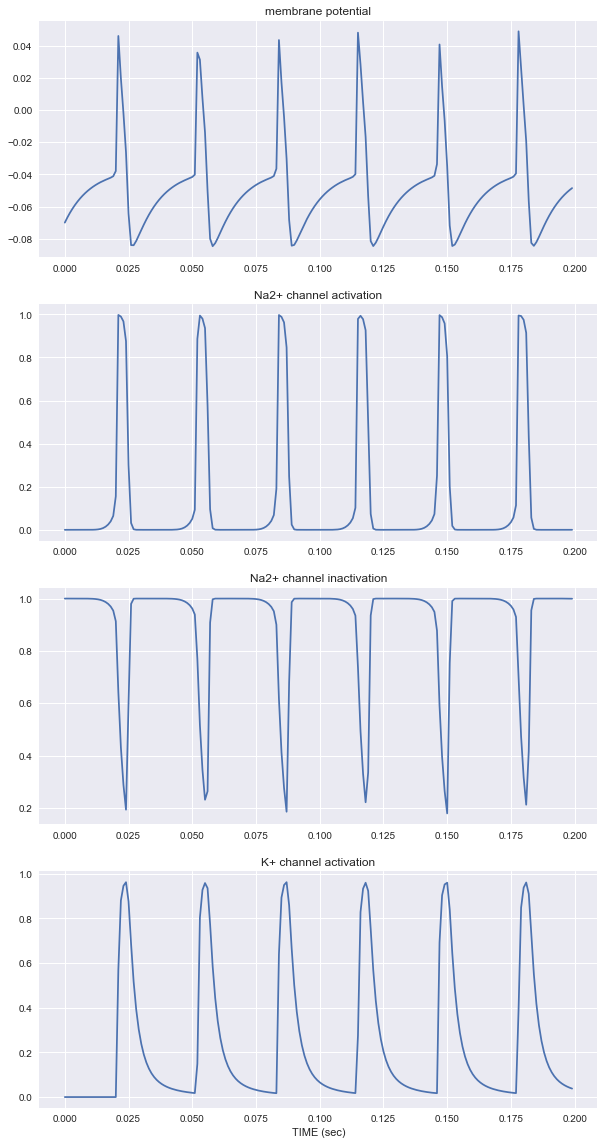

In [10]:
# plot the results

plt.figure(figsize=(10,20))
plt.subplot(4,1,1)
plt.plot(t, state[:,0])
plt.title('membrane potential')
plt.subplot(4,1,2)
plt.plot(t, state[:,1])
plt.title('Na2+ channel activation')
plt.subplot(4,1,3)
plt.plot(t, state[:,2])
plt.title('Na2+ channel inactivation')
plt.subplot(4,1,4)
plt.plot(t, state[:,3])
plt.title('K+ channel activation')
plt.xlabel('TIME (sec)')
plt.show()